In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
%matplotlib inline

### Explorando os dados

In [4]:
data = pd.read_csv("./LLM.csv")

In [5]:
data.head()

,Text,Label
0,y r u always l8 to the meetings?,student
1,The project team embraced a user-centric desig...,ai
2,"i dont like dealing with risks, it's too stres...",student
3,"i dont worry about reliability, it's good enough",student
4,"i dont care about human-centered design, just ...",student


### Divider dados de teste e treino

In [7]:
features = data["Text"].to_numpy()
features

array(['y r u always l8 to the meetings?',
       'The project team embraced a user-centric design approach for product development.',
       "i dont like dealing with risks, it's too stressful", ...,
       'i dont care about multi-method approaches, just give me the results',
       'i dont understand variables, just give me the answer',
       "i dont worry about encryption, it's overrated"], dtype=object)

In [8]:
outputs = data["Label"].to_numpy()
outputs

array(['student', 'ai', 'student', ..., 'student', 'student', 'student'],
      dtype=object)

In [9]:
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(
    features, outputs, test_size=0.3
)
x_train_raw[:5], x_test_raw[:5], y_train_raw[:5], y_test_raw[:5]

(array(["i dont like artificial intelligence, it's too unpredictable",
        "i dont like agile approaches, they're too unpredictable",
        'In the world of robotics, advancements in artificial intelligence enable more complex tasks.',
        'i dont need practical implications, just tell me what to do',
        'The findings have practical implications for real-world applications.'],
       dtype=object),
 array(['The data collection process was systematic and thorough.',
        'The analysis considered the correlation between social media usage and mental health.',
        'i dont talk about limitations, it makes me look bad',
        'The data analysis software used is widely accepted in the field.',
        'The research design ensured data privacy and confidentiality.'],
       dtype=object),
 array(['student', 'student', 'ai', 'student', 'ai'], dtype=object),
 array(['ai', 'ai', 'student', 'ai', 'ai'], dtype=object))

In [11]:
np.where((y_test_raw != 'ai') & (y_test_raw != 'student'))

(array([], dtype=int64),)

In [12]:
y_test_raw

array(['ai', 'ai', 'student', 'ai', 'ai', 'ai', 'ai', 'student',
       'student', 'student', 'ai', 'student', 'student', 'ai', 'ai',
       'student', 'student', 'student', 'student', 'ai', 'ai', 'ai',
       'student', 'ai', 'student', 'student', 'student', 'student', 'ai',
       'student', 'student', 'student', 'student', 'ai', 'student', 'ai',
       'ai', 'ai', 'student', 'student', 'student', 'student', 'student',
       'student', 'ai', 'ai', 'student', 'ai', 'student', 'ai', 'student',
       'student', 'student', 'ai', 'student', 'student', 'student',
       'student', 'student', 'student', 'student', 'student', 'student',
       'ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'student', 'ai',
       'student', 'ai', 'student', 'ai', 'ai', 'student', 'student',
       'student', 'ai', 'student', 'student', 'ai', 'ai', 'student',
       'student', 'ai', 'ai', 'ai', 'student', 'student', 'student', 'ai',
       'student', 'student', 'student', 'student', 'ai', 'ai', 'ai', 'ai',
     

### Tratamento dos Dados

In [13]:
import nltk

nltk.download(["vader_lexicon"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mateusoliveirasantos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer

import json


class DetectAITransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.common_words: list[str] = self._load_common_words()
        self.most_words: set[str] = self._load_most_words()

        self._sia = SentimentIntensityAnalyzer()

    def _load_common_words(self):
        with open("words.txt", "r") as words_file:
            return words_file.read().splitlines()

    def _load_most_words(self):
        with open("words_dictionary.json", "r") as words_file:
            most_words: dict = json.load(words_file)

        return set(most_words.keys())

    def _parse_text_words(self, text: str, stop_words: set[str] = set()) -> list[str]:
        words = (
            text.lower()
            .replace(".", "")
            .replace(",", "")
            .replace("!", "")
            .replace("?", "")
            .replace("-", " ")
            .replace("'s", "")
            .replace("'", "")
            .split()
        )

        final_words = []
        for word in words:
            if word not in stop_words:
                final_words.append(word)

        return final_words

    def _has_perfect_vocabulary(self, text: str):
        local_words = self._parse_text_words(text)
        for word in local_words:
            if word not in self.most_words:
                return 0

        return 1

    def _complexity_index(self, text: str):
        stop_words, words = self.common_words[:30], self.common_words[30:]
        local_words = self._parse_text_words(
            text, stop_words=stop_words
        )  # Ignore the 30 most common words which are mostly prepositions

        words_hash = set(words)
        words_size = len(words)

        total_score = 0
        not_appeared = 0
        for local_word in local_words:
            score = 0
            if local_word in words_hash:
                # 0 if this word is the most common of all
                # 1 if it is the rarest
                score = self.common_words.index(local_word) / words_size
            else:
                not_appeared += 1

            total_score += score

        # We are ignoring words which did not appear because they could be
        # a vocabulary mistake
        return total_score / (len(local_words) - not_appeared)

    def _negativity_score(self, text: str):
        return self._sia.polarity_scores(text)["neg"]

    def _transform_text(self, text: str):
        return np.array(
            [
                self._has_perfect_vocabulary(text),
                self._complexity_index(text),
                self._negativity_score(text),
            ]
        )

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self._transform_text(x) for x in X])

Isso será necessário porque o LDA não aceita matrizes "sparse"; precisamos convertê-las em "dense" antes.

In [15]:
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

In [26]:
text_pipeline = Pipeline([("vectorize_text", DetectAITransformer())])
text_pipeline

Pipeline(steps=[('vectorize_text', DetectAITransformer())])

In [27]:
x_train = text_pipeline.fit_transform(x_train_raw)
x_train

array([[1.        , 0.25399432, 0.483     ],
       [1.        , 0.20960057, 0.26      ],
       [1.        , 0.26807921, 0.        ],
       ...,
       [1.        , 0.34106346, 0.259     ],
       [1.        , 0.16204669, 0.26      ],
       [1.        , 0.38498581, 0.        ]])

In [28]:
x_test = text_pipeline.transform(x_test_raw)
x_test

array([[1.        , 0.3919708 , 0.        ],
       [1.        , 0.17816752, 0.        ],
       [1.        , 0.14997719, 0.304     ],
       [1.        , 0.12019175, 0.        ],
       [1.        , 0.20547445, 0.        ],
       [1.        , 0.12465531, 0.        ],
       [1.        , 0.1312179 , 0.        ],
       [1.        , 0.14997719, 0.304     ],
       [1.        , 0.08846563, 0.232     ],
       [0.        , 0.08336713, 0.273     ],
       [1.        , 0.30388281, 0.        ],
       [0.        , 0.11646729, 0.495     ],
       [1.        , 0.16436392, 0.        ],
       [0.        , 0.12104623, 0.        ],
       [1.        , 0.19273549, 0.        ],
       [1.        , 0.16887447, 0.226     ],
       [1.        , 0.18917275, 0.26      ],
       [1.        , 0.09801072, 0.        ],
       [1.        , 0.1913017 , 0.364     ],
       [1.        , 0.31527102, 0.        ],
       [1.        , 0.11154197, 0.        ],
       [1.        , 0.34392741, 0.        ],
       [1.

In [29]:
label_encoder = LabelEncoder()

In [30]:
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
y_train, y_test

(array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 

In [31]:
label_encoder.classes_

array(['ai', 'student'], dtype=object)

### Function for plotting ROC

In [39]:
def plot_roc(roc_auc, false_positive_rate, true_positive_rate):
    plt.figure(figsize=(6, 6))
    plt.title("Receiver Operating Characteristics")
    plt.plot(
        false_positive_rate,
        true_positive_rate,
        color="red",
        label="AUC = {:.2f}".format(roc_auc),
    )
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.axis("tight")
    plt.ylabel("True Positive Rtae")
    plt.xlabel("False Positive Rtae")

### LDA

In [53]:
y_test

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,

In [52]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

y_prob_lda = lda.predict_proba(x_test)[:, 1]
y_pred_lda = np.where(y_prob_lda > 0.5, 1, 0)
y_prob_lda

array([0.03331008, 0.16894911, 0.95427811, 0.24753588, 0.13945948,
       0.24069869, 0.23088279, 0.95427811, 0.92466778, 0.95685083,
       0.06681098, 0.99761338, 0.18565401, 0.23815233, 0.15264148,
       0.85235688, 0.88859973, 0.28340005, 0.97243435, 0.06115255,
       0.26115189, 0.04883792, 0.9023467 , 0.11843881, 0.99361094,
       0.91757971, 0.24518363, 0.11258704, 0.15095928, 0.97910519,
       0.3179509 , 0.31684956, 0.25955147, 0.297337  , 0.87143581,
       0.05067816, 0.16225657, 0.00852727, 0.93814057, 0.72502306,
       0.99662794, 0.95427811, 0.93406236, 0.89573841, 0.18175974,
       0.07277984, 0.1352515 , 0.04272502, 0.14528649, 0.24774308,
       0.10400702, 0.88859973, 0.23490898, 0.20019894, 0.95427811,
       0.95427811, 0.24518363, 0.94344706, 0.96426834, 0.64070792,
       0.99856929, 0.99980209, 0.17452586, 0.14972296, 0.13498922,
       0.20228907, 0.15440703, 0.07083719, 0.34379902, 0.33722214,
       0.92413811, 0.33021731, 0.21852048, 0.28343532, 0.31684

In [54]:
confusion_matrix_lda = confusion_matrix(y_test, y_pred_lda)
confusion_matrix_lda

array([[135,  12],
       [ 61, 123]])

In [38]:
false_positive_rate_lda, true_positive_rate_lda, thresholds = roc_curve(y_test, pred)
roc_auc_lda = auc(false_positive_rate_lda, true_positive_rate_lda)
roc_auc_lda

np.float64(0.7934228039041703)

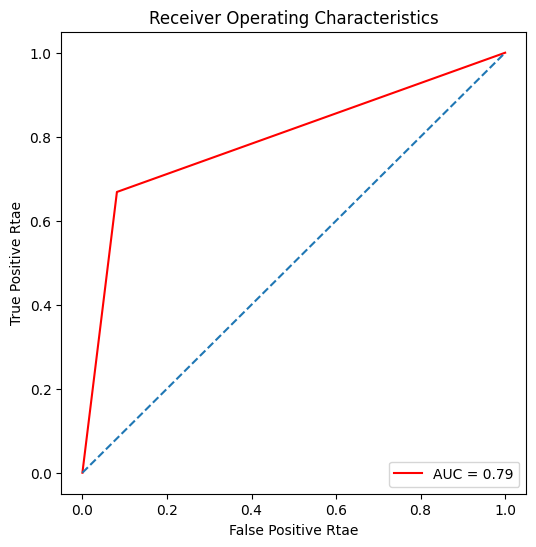

In [40]:
plot_roc(roc_auc_lda, false_positive_rate_lda, true_positive_rate_lda)

### QDA

In [69]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
pred = qda.predict(x_test)

In [70]:
confusion_matrix_qda = confusion_matrix(y_test, pred)
confusion_matrix_qda

array([[135,  12],
       [ 61, 123]])

In [71]:
false_positive_rate_qda, true_positive_rate_qda, thresholds = roc_curve(y_test, pred)
roc_auc_qda = auc(false_positive_rate_qda, true_positive_rate_qda)

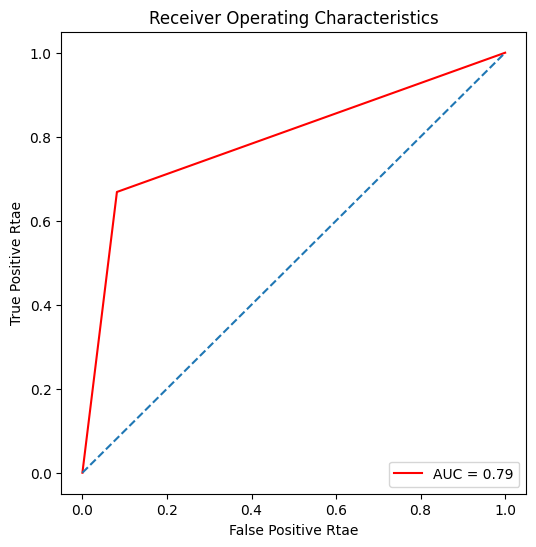

In [72]:
plot_roc(roc_auc_qda, false_positive_rate_qda, true_positive_rate_qda)

### K-nn

In [62]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
pred

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,

In [63]:
confusion_matrix_knn = confusion_matrix(y_test, pred)
confusion_matrix_knn

array([[126,  21],
       [ 32, 152]])

In [66]:
false_positive_rate_knn, true_positive_rate_knn, thresholds = roc_curve(y_test, pred)
roc_auc_knn = auc(false_positive_rate_knn, true_positive_rate_knn)

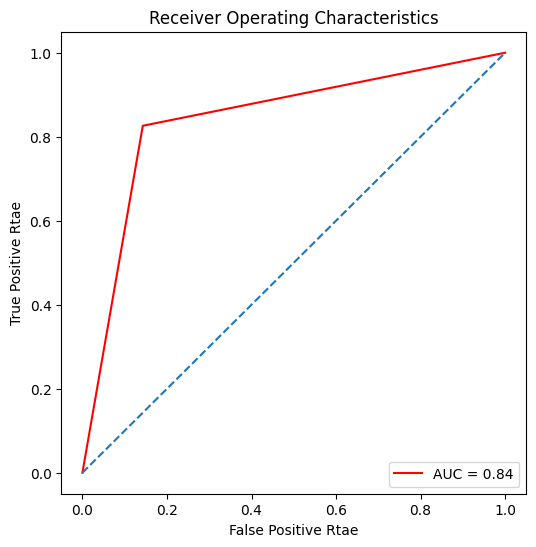

In [67]:
plot_roc(roc_auc_knn, false_positive_rate_knn, true_positive_rate_knn)

In [93]:
svm = SVC(kernel="sigmoid")
svm.fit(x_train, y_train)
pred = svm.predict(x_test)

In [94]:
confusion_matrix_svm = confusion_matrix(y_test, pred)
confusion_matrix_svm

array([[138,   9],
       [ 63, 121]])

In [95]:
false_positive_rate_svm, true_positive_rate_svm, thresholds = roc_curve(y_test, pred)
roc_auc_svm = auc(false_positive_rate_svm, true_positive_rate_svm)

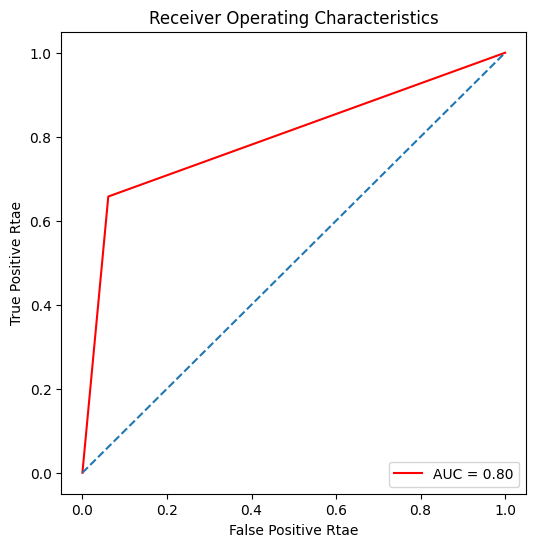

In [97]:
plot_roc(roc_auc_svm, false_positive_rate_svm, true_positive_rate_svm)

In [100]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
pred = rfc.predict(x_test)

In [101]:
confusion_matrix_svm = confusion_matrix(y_test, pred)
confusion_matrix_svm

array([[136,  11],
       [ 18, 166]])

In [102]:
false_positive_rate_rfc, true_positive_rate_rfc, thresholds = roc_curve(y_test, pred)
roc_auc_rfc = auc(false_positive_rate_rfc, true_positive_rate_rfc)

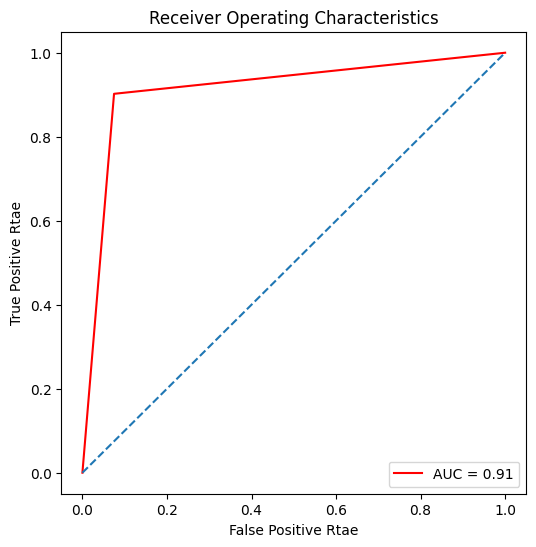

In [103]:
plot_roc(roc_auc_rfc, false_positive_rate_rfc, true_positive_rate_rfc)